# Download and prepare the data

## Download and load

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for project imports
import sys
from pathlib import Path

root = Path.cwd().parent
sys.path.append(str(root))

In [75]:
from src.kaggle_utils import download_kaggle_dataset

# Download the dataset from Kaggle
download_kaggle_dataset('uciml/adult-census-income', str(root / Path("data/raw")))

# Load the dataset
data = pd.read_csv(str(root / Path("data/raw/adult-census-income/adult.csv")))
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### -> Observations <-

- Missing values marked as "?" in categorical values
- Target value "income" is categorical with 2 possible values

## Prepare data and features lists

In [76]:
from sklearn.model_selection import train_test_split

# Convert target variable to numeric
data["income"] = (data["income"] == '>50K').astype(int)

X = data.drop(columns=['income'])
y = data['income']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

Numeric features: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Categorical features: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


# Analyze the data

In [77]:
# Amount of data 
print(f"Data shape: {data.shape}")

# Check for unknown values in categorical columns (sorted)
unknown_values = data[categorical_features].apply(lambda x: (x == '?').sum())
unknown_values = unknown_values[unknown_values > 0].sort_values(ascending=False)
print("\nUnknown values by column:")
print(unknown_values)

# Amount of different values in categorical columns (sorted)
unique_values = data[categorical_features].nunique().sort_values(ascending=False)
print("\nUnique values by column:")
print(unique_values)


Data shape: (32561, 15)

Unknown values by column:
occupation        1843
workclass         1836
native.country     583
dtype: int64

Unique values by column:
native.country    42
education         16
occupation        15
workclass          9
marital.status     7
relationship       6
race               5
sex                2
dtype: int64


### -> Observations <-

- Percentage of unknown values is not high. Should be imputed
- Some categories have a lot of unique values. Might be too much for OneHot imputer

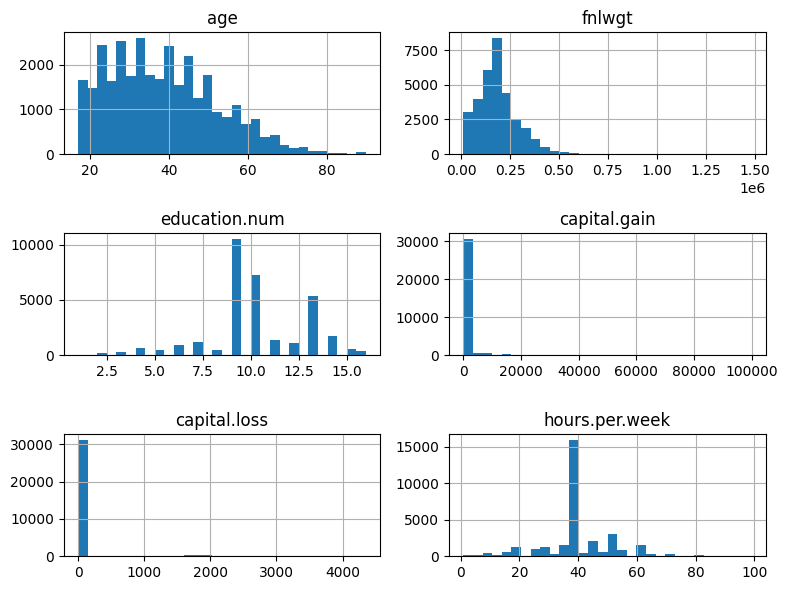

In [13]:
data.hist(bins=30, figsize=(8, 6))
plt.tight_layout()
plt.show()

In [78]:
# Explore numeric feature correlations
numeric_data = data.select_dtypes(include=['int64', 'float64'])
numeric_data.head()

corr_matrix = numeric_data.corr()
corr_matrix["income"].sort_values(ascending=False).drop("income")

education.num     0.335154
age               0.234037
hours.per.week    0.229689
capital.gain      0.223329
capital.loss      0.150526
fnlwgt           -0.009463
Name: income, dtype: float64

### -> Observations <-

- No high correlation with any numeric feature 

# Preprocess the data

## Missing data

In [48]:
from sklearn.impute import SimpleImputer

# Imputation for missing categorical values
categorical_imputer = SimpleImputer(strategy='most_frequent', missing_values='?')

## Categorical encoding

In [49]:
from sklearn.preprocessing import OneHotEncoder

# Categorical encoding
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## Scaling

In [51]:
from sklearn.preprocessing import StandardScaler

# Standardization for numeric features
numeric_scaler = StandardScaler()

## Preprocessing Pipeline

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('encoder', categorical_encoder)
        ]), categorical_features),
        ('num', numeric_scaler, numeric_features)
    ]
)

# Feature engineering

# Prediction Models

## Logistic Regression

In [84]:
from sklearn.linear_model import LogisticRegression

logistic_reg_model = LogisticRegression()

# Full pipeline
logistic_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logistic_reg_model)
])

# Train the model
logistic_reg_pipeline.fit(X_train, y_train)

# Evaluate the model
train_accuracy = logistic_reg_pipeline.score(X_train, y_train)
valid_accuracy = logistic_reg_pipeline.score(X_valid, y_valid)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")


Training Accuracy: 0.8511
Validation Accuracy: 0.8531


### -> Results <-

**Initial result:**   
Training Accuracy: 0.8511  
Validation Accuracy: 0.8531

Quite good

## Decision Tree

In [85]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier()

# Full pipeline
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', decision_tree_model)
])

# Train the model
decision_tree_pipeline.fit(X_train, y_train)

# Evaluate the model
train_accuracy = decision_tree_pipeline.score(X_train, y_train)
valid_accuracy = decision_tree_pipeline.score(X_valid, y_valid)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")

Training Accuracy: 1.0000
Validation Accuracy: 0.8173


### -> Results <-

**Initial result:**   
Training Accuracy: 1.0000  
Validation Accuracy: 0.8170

Overfitting

## Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier()

# Full pipeline
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', random_forest_model)
])

# Train the model
random_forest_pipeline.fit(X_train, y_train)

# Evaluate the model
train_accuracy = random_forest_pipeline.score(X_train, y_train)
valid_accuracy = random_forest_pipeline.score(X_valid, y_valid)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")


Training Accuracy: 1.0000
Validation Accuracy: 0.8532


### -> Results <-

**Initial result:**   
Training Accuracy: 1.0000  
Validation Accuracy: 0.8526

Overfitting

## Gradient Boosting

In [87]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='error')

# Full pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Evaluate the model
train_accuracy = xgb_pipeline.score(X_train, y_train)
valid_accuracy = xgb_pipeline.score(X_valid, y_valid)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")


Training Accuracy: 0.9032
Validation Accuracy: 0.8675


### -> Results <-

**Initial result:**   
Training Accuracy: 0.9032  
Validation Accuracy: 0.8675

Good

## Ensembles

In [88]:
# Ensemble of models
from sklearn.ensemble import VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('log_reg', logistic_reg_pipeline),
    ('dec_tree', decision_tree_pipeline),
    ('rand_forest', random_forest_pipeline),
    ('xgb', xgb_pipeline)
], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the model
train_accuracy = ensemble_model.score(X_train, y_train)
valid_accuracy = ensemble_model.score(X_valid, y_valid)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {valid_accuracy:.4f}")


Training Accuracy: 0.9397
Validation Accuracy: 0.8647


### -> Results <-

**Initial result:**   
Training Accuracy: 0.9397
Validation Accuracy: 0.8647

Good

## Compare and visualize model results

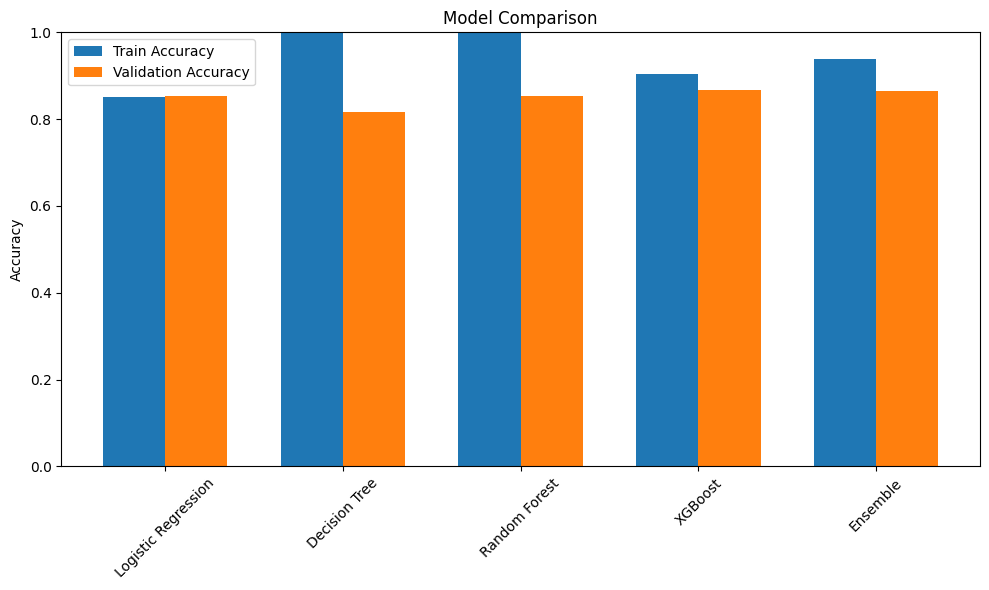

In [90]:
# Compare and visualize model results
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Ensemble']
train_accuracies = [
    logistic_reg_pipeline.score(X_train, y_train),
    decision_tree_pipeline.score(X_train, y_train),
    random_forest_pipeline.score(X_train, y_train),
    xgb_pipeline.score(X_train, y_train),
    ensemble_model.score(X_train, y_train)
]
valid_accuracies = [
    logistic_reg_pipeline.score(X_valid, y_valid),
    decision_tree_pipeline.score(X_valid, y_valid),
    random_forest_pipeline.score(X_valid, y_valid),
    xgb_pipeline.score(X_valid, y_valid),
    ensemble_model.score(X_valid, y_valid)
]

# Plotting
x = np.arange(len(model_names))
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
bars2 = ax.bar(x + width/2, valid_accuracies, width, label='Validation Accuracy')
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()